# Current work flows are:
1. read 3D data cubes (this is also time consuming for large data, but no room for improvement I believe)
2. remap them to a spherical coordinates seen by an observer (see `get_index_all` function)
3. save intermediate outputs for the remapped physical variables
4. calculate I, Q, and U at every position with an assumed dust model
5. intergrate along the LOSs (can vary range of integration)

Since `Step 2` is time consuming and we may want to apply different dust models at `Step 4`, I added `Step 3`. Now the problem is the intermediate outputs are also very large (~ original data cube) and this should be done again for different observer's position. If we can make `Step 2` faster, we don't need `Step 3` and the intermediate outputs. I have talked with Miak Juvela and he has a machinery that can handle `Step 2` much faster with pre-caculated emissivity data (equivalent to `Step 4`, but done in original Cartesian box). Changing observer's position will be straightforward.

# Desired work flows are:
1. read 3D data cubes (this is also time consuming for large data, but no room for improvement I believe)
2. calculate I, Q, and U at every position in **the orignal Cartesian box** with an assumed dust model (possibly, dump the emissivity data)
3. intergrate along the LOSs efficiently


In [1]:
%matplotlib inline

In [2]:
import numpy as np
import healpy as hp
import astropy.constants as c
import astropy.units as u
import os,re

# pyathena is needed to read in 3D data cube from Athena VTK dumps
# https://github.com/changgoo/pyathena
import pyathena as pa

In [3]:
def make_directory(domain,smax,Nside=4,center=[0.,0.,0.]):
    '''
        Make directories for outputs
    '''
    losdir=domain['losdir']
    step=domain['step']
    stepdir='%s%s-%d' % (losdir,step,smax)
    cstring='x%dy%dz%d' % (center[0],center[1],center[2])
    outdir='%s%s-%d/Nside%d-%s' % (losdir,step,smax,Nside,cstring)
    
    if not os.path.isdir(losdir): os.mkdir(losdir)
    if not os.path.isdir(stepdir): os.mkdir(stepdir)
    if not os.path.isdir(outdir): os.mkdir(outdir)

def get_joffset(domain):
    '''
        Calculate y offset due to shear
        vy0 = -q*Omega*Lx
        yshear = vy0*dt
        joffset = |yshear/Ly|
    '''
    Omega=domain['Omega']
    qshear=domain['qshear'] 
    Lx=domain['right_edge'][0]-domain['left_edge'][0]
    Ly=domain['right_edge'][1]-domain['left_edge'][1]
    qomL=qshear*Omega*Lx
    yshear=qomL*domain['time']
    deltay=np.mod(yshear,Ly)
    joffset=deltay/domain['dx'][1]

    return joffset

def get_hat(nside,ipix):
    '''
        Obtain unit vector on the spherical coordinate
    '''

    theta,phi = hp.pix2ang(nside,ipix)
    rhat=[np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)]
    thhat=[np.cos(theta)*np.cos(phi),np.cos(theta)*np.sin(phi),-np.sin(theta)]
    phhat=[-np.sin(phi),np.cos(phi),0]
    hat={'Z':rhat,'X':thhat,'Y':phhat}

    return hat

def cc_idx(le,dx,pos):
    '''
        Get cell-centered indices for the given 3D position
    '''
    if np.array(pos).ndim == 2:
        le=le[:,np.newaxis]
        dx=dx[:,np.newaxis]
    elif np.array(pos).ndim == 3:
        le=le[:,np.newaxis,np.newaxis]
        dx=dx[:,np.newaxis,np.newaxis]

    idx=(pos-le-0.5*dx)/dx
    return idx

def los_idx_all(hat,domain,smin=0.,smax=3000.,ds=1.,center=[0,0,0],zmax_cut=True):
    '''
        Get corresponding cell-centered indices in the original Cartesian domain of all LOSs
        No BCs applied yet
    '''
    zmax=domain['right_edge'][2]-0.5*domain['dx'][2]
    zmin=domain['left_edge'][2]+0.5*domain['dx'][2]
    xhat=hat[0][:,np.newaxis]
    yhat=hat[1][:,np.newaxis]
    zhat=hat[2][:,np.newaxis]

    sarr=np.arange(smin,smax,ds)
    xarr=xhat*sarr + center[0]
    yarr=yhat*sarr + center[1]
    zarr=zhat*sarr + center[2]

    le=domain['left_edge']
    dx=domain['dx']
    if np.abs(le[2]) < smax: le[2]=-smax
    iarr = cc_idx(le,dx,[xarr,yarr,zarr])

    return iarr,[xarr,yarr,zarr],sarr

def get_index_all(domain,Nside,center,smax,ds):
    '''
        Get corresponding cell-centered indices in the original Cartesian domain of all LOSs
        Applying shearing-periodic BCs if necessary
        Return both integer indices and floating point residuals for interpolation as well as 
            background shear velocity (if necessary)
    '''

    npix=hp.nside2npix(Nside)
    ipix=np.arange(npix)
    hat=get_hat(Nside,ipix)
    iarr,xarr,sarr=los_idx_all(hat['Z'],domain,smin=0,smax=smax,ds=ds,center=center)

    Nx,Ny,Nz=domain['Nx']
    vy0=None

    xdiv,xidx=np.divmod(iarr[0],Nx) # this is for periodic BCs
    if domain['shear']: # this is for shearing-periodic BCs
        joffset=get_joffset(domain)
        yidx=np.remainder(iarr[1]+xdiv*joffset,Ny)
        if 'velocity2' in domain['fields']:
            Omega=domain['Omega']
            qshear=domain['qshear']
            vy0 = -qshear*Omega*xarr[0]
    else:
        yidx=np.remainder(iarr[1],Ny) # this is for periodic BCs
        vy0 = None
    zidx=iarr[2]

    x0 = xidx.astype(np.intp)
    y0 = yidx.astype(np.intp)
    z0 = zidx.astype(np.intp)
    dx = xidx - x0
    dy = yidx - y0
    dz = zidx - z0

    return x0,y0,z0,dx,dy,dz,vy0

def extend_data(domain,data,smax):
    '''
        Copy YZ and XZ slices at i=0 and j=0 to i=Nx and j=Ny, respectively.
        Applying corresponding BCs
    '''
    dslicey=data[:,0,:]
    newdata=np.concatenate((data,dslicey[:,np.newaxis,:]),axis=1) # this is for periodic BCs in y-dir

    if domain['shear']: # this is for shearing-periodic BCs in x-dir
        joffset=get_joffset(domain)
        d1=np.roll(newdata[:,:,0],-joffset.astype(np.int),axis=1)
        d2=np.roll(newdata[:,:,0],-(joffset.astype(np.int)+1),axis=1)
        dj=joffset-joffset.astype(np.int)
        dslicex=d1*(1-dj)+d2*dj
    else: # this is for periodic BCs in x-dir
        dslicey=data[:,:,0]

    newdata=np.concatenate((newdata,dslicex[:,:,np.newaxis]),axis=2)

    Nz, Ny, Nx = newdata.shape
    New_Nz=smax/domain['dx'][2]

    if New_Nz>(Nz/2):
        zeros=np.zeros((int(New_Nz-Nz/2),Ny,Nx))
        newdata=np.concatenate((zeros,newdata,zeros),axis=0)
    return newdata

def los_dump(ds,domain,deltas,smax,fields=['density'],
             Nside=4,center=[0,0,0],force_write=False):
    '''
        Get and save trilinear interpolated data field(s) along all LOSs (healpix angle, los distance)
        using Athena VTK data dump
    '''
    losdir=domain['losdir']
    step=domain['step']
    cstring='x%dy%dz%d' % (center[0],center[1],center[2])
    outdir='%s%s-%d/Nside%d-%s' % (losdir,step,smax,Nside,cstring)
 
    x0,y0,z0,dx,dy,dz,vy0 = get_index_all(domain,Nside,center,smax,deltas)

    for f in fields:
        outfile='%s/%s.npy' % (outdir,f)
        if not os.path.isfile(outfile) or force_write:
            print('interpolating and writing: %s' % f)
            data=read_data(ds,f,domain)
            data=extend_data(domain,data,smax)
            dlos=data[z0  ,y0  ,x0  ]*(1-dz)*(1-dy)*(1-dx) +\
                 data[z0+1,y0  ,x0  ]*dz*(1-dy)*(1-dx) +\
                 data[z0  ,y0+1,x0  ]*(1-dz)*dy*(1-dx) +\
                 data[z0  ,y0  ,x0+1]*(1-dz)*(1-dy)*dx +\
                 data[z0+1,y0+1,x0  ]*dz*dy*(1-dx) +\
                 data[z0+1,y0  ,x0+1]*dz*(1-dy)*dx +\
                 data[z0  ,y0+1,x0+1]*(1-dz)*dy*dx +\
                 data[z0+1,y0+1,x0+1]*dz*dy*dx
 
            #dlos=d000+d100+d010+d001+d110+d101+d011+d111
            if f is 'velocity2' and 'Omega' in domain: dlos += vy0
            np.save(outfile,dlos)

def los_dump_from_data(data,domain,deltas,smax,f,
             Nside=4,center=[0,0,0],force_write=False):
    '''
        Get and save trilinear interpolated data field along all LOSs (healpix angle, los distance)
        using 3D array
    '''
    losdir=domain['losdir']
    step=domain['step']
    cstring='x%dy%dz%d' % (center[0],center[1],center[2])
    outdir='%s%s-%d/Nside%d-%s' % (losdir,step,smax,Nside,cstring)
 
    x0,y0,z0,dx,dy,dz,vy0 = get_index_all(domain,Nside,center,smax,deltas)

    outfile='%s/%s.npy' % (outdir,f)
    if not os.path.isfile(outfile) or force_write:
        print('interpolating and writing: %s' % f)
        data=extend_data(domain,data,smax)
        dlos=data[z0  ,y0  ,x0  ]*(1-dz)*(1-dy)*(1-dx) +\
             data[z0+1,y0  ,x0  ]*dz*(1-dy)*(1-dx) +\
             data[z0  ,y0+1,x0  ]*(1-dz)*dy*(1-dx) +\
             data[z0  ,y0  ,x0+1]*(1-dz)*(1-dy)*dx +\
             data[z0+1,y0+1,x0  ]*dz*dy*(1-dx) +\
             data[z0+1,y0  ,x0+1]*dz*(1-dy)*dx +\
             data[z0  ,y0+1,x0+1]*(1-dz)*dy*dx +\
             data[z0+1,y0+1,x0+1]*dz*dy*dx
 
        if f is 'velocity2' and 'Omega' in domain: dlos += vy0
        np.save(outfile,dlos)

def select_phase(temperature,density,phase='warm'):
    '''
        Select gas phase (setting density[~phase]=0)
        
        phase=['whole','warm','cold','2p','lowd']
        
    '''
    T1=5050.
    T2=2.e4
    dmax=50
    if phase is 'whole': 
        return density
    elif phase is 'warm':
        idx = (temperature < T1) | (temperature > T2)
    elif phase is 'cold': 
        idx = (temperature >= T1) 
    elif phase is '2p': 
        idx = (temperature > T2) 
    elif phase is 'lowd': 
        idx = (temperature > T2) | (density > dmax)
    else:
        print("{} is not supported".format(phase))
        return -1
    
    dnew = np.copy(density)
    dnew[idx] = 0.0

    return dnew

def setup_domain(fname,purpose='dustpol',shear=True):
    '''
        Setting up domain information for the data reader
        fields= [density, magnetic_field] for synthetic dust polarization 
            or  [density, velocity, temperature] for synthetic HI 21cm line
            
        Inputs
        ------
        fname: string
            vtk data dump file name
            
        Outputs
        -------
        ds: AthenaDataSet (pyathena class)
        
        domain: AthenaDomain (pyathena class)
        
        Parameters
        ----------
        purpose: string
            [dustpol, HI]
            set relevant data field names for type of synthetic observations
        
        shear: bool
            if True, set shear parameters and apply shearing-periodic BCs
    '''
    dir, id, step, ext, mpi = pa.parse_filename(fname)
    ds=pa.AthenaDataSet(fname)
    parfname='%s/%s.par' % (ds.dir,ds.id)
    par,blocks,fields=pa.parse_par(parfname)

    domain=ds.domain
    fields=['density']
    if purpose == 'HI':
        fields.append('temperature')
        fields.append('velocity1')
        fields.append('velocity2')
        fields.append('velocity3')
    elif purpose == 'dustpol':
        fields.append('magnetic_field1')
        fields.append('magnetic_field2')
        fields.append('magnetic_field3')
    else:
        raise ValueError('purpose={} is not supported'.format(purpose))

    domain['fields']=fields
    domain['shear']=shear
    if shear:
        if (not 'qshear' in par['problem']) or \
           (not 'Omega' in par['problem']):
            raise ValueError('Shear parameters cannot be found in parameter files')
        domain['qshear']=eval(par['problem']['qshear'][0])
        domain['Omega']=eval(par['problem']['Omega'][0])
        domain['losdir']=dir+'los/'
    else:
        domain['losdir']=dir+'los-periodic/'
    domain['step']=step

    return ds,domain


def read_data(ds,field,domain,vy0_subtract=True):
    '''
        Wrapper for an Athena vtk output reader (pyathena)
        
        Inputs
        ------
        ds: AthenaDataSet (pyathena class)
        
        field: string
            name of the data field to be read
            
        domain: AthenaDomain (pyathena class)
            domain information (including shear information)
        
        
        Parameters
        ----------
        vy0_substract: bool
            if True, background shear velocity will be subtracted
    '''
    if field is 'temperature':
        coolftn=pa.coolftn()
        data=coolftn.get_temp(ds.read_all_data('T1'))
    elif field is 'velocity2':
        data = ds.read_all_data(field)
        if vy0_subtract:
            r3d,x3d,y3d,z3d=pa.pos3d(domain)
            vy0=-domain['qshear']*domain['Omega']*x3d
            data -= vy0
    else:
        data = ds.read_all_data(field)
    
    return data

def calc_IQU(domain,deltas,smax,Nside=4,center=[0,0,0],
    phase='whole',recal=False,file_write=False):
    '''
        Calculate dI, dQ, dU at every healpix angle and LOS distance
        Sky projection can be obatind by simply sum up a range of LOS distances
    '''
    losdir=domain['losdir']
    step=domain['step']
    cstring='x%dy%dz%d' % (center[0],center[1],center[2])
    stepdir='%s%s-%d' % (losdir,step,smax)
    outdir='%s%s-%d/Nside%d-%s' % (losdir,step,smax,Nside,cstring)

    Imap_file='%s/Imap.npy' % outdir
    Qmap_file='%s/Qmap.npy' % outdir
    Umap_file='%s/Umap.npy' % outdir

    if os.path.isfile(Imap_file) & os.path.isfile(Qmap_file) & \
       os.path.isfile(Umap_file) & (recal==False):
        I=np.load(Imap_file)
        Q=np.load(Qmap_file)
        U=np.load(Umap_file)
        return I,Q,U
    else:
        outfile='%s/%s%s' % (outdir,'density','.npy')
        nH=np.load(outfile)
        if phase != 'whole':
            outfile='%s/%s%s' % (outdir,'temperature','.npy')
            if os.path.isfile(outfile):
                temperature=np.load(outfile)
                nH=select_phase(temperature,nH,phase=phase)    
        outfile='%s/%s%s' % (outdir,'magnetic_field1','.npy')
        B1=np.load(outfile)
        outfile='%s/%s%s' % (outdir,'magnetic_field2','.npy')
        B2=np.load(outfile)
        outfile='%s/%s%s' % (outdir,'magnetic_field3','.npy')
        B3=np.load(outfile)
    
        npix=hp.nside2npix(Nside)
        ipix = np.arange(npix)
        hat=get_hat(Nside,ipix)
        Bz=hat['Z'][0][:,np.newaxis]*B1+hat['Z'][1][:,np.newaxis]*B2+hat['Z'][2][:,np.newaxis]*B3
        Bx=hat['X'][0][:,np.newaxis]*B1+hat['X'][1][:,np.newaxis]*B2+hat['X'][2][:,np.newaxis]*B3
        By=hat['Y'][0][:,np.newaxis]*B1+hat['Y'][1][:,np.newaxis]*B2 #+hat['Y'][2]*B3 -- this is zer
 
        args={'Bnu':41495.876171482356, 'sigma':1.2e-26, 'p0':0.2, 'attenuation': 0}
        Bnu=args['Bnu']
        p0=args['p0']
        sigma=args['sigma']
 
        Bperp2=Bx*Bx+By*By
        B2=Bperp2+Bz*Bz
        cos2phi=(By*By-Bx*Bx)/Bperp2
        sin2phi=-Bx*By/Bperp2*2
        cosgam2=Bperp2/B2
 
        ds=deltas*3.085677581467192e+18
        dtau=sigma*nH*ds
 
        I=Bnu*(1.0-p0*(cosgam2-2./3.0))*dtau
        Q=p0*Bnu*cos2phi*cosgam2*dtau
        U=p0*Bnu*sin2phi*cosgam2*dtau
 
        if file_write:
            np.save('%s/Imap.npy' % outdir,I)
            np.save('%s/Qmap.npy' % outdir,Q)
            np.save('%s/Umap.npy' % outdir,U)
 
        return I,Q,U

In [4]:
import numpy as np
import os,glob

#base='/tigress/changgoo/'
base='/global/cscratch1/sd/changgoo/'
id='R8_16pc_newacc'

Nside=32
center=[0,0,0]
smax=3500
for itime in range(300,301,1):
    fname='%s%s/id0/%s.%4.4d.vtk' % (base,id,id,itime)
    if os.path.isfile(fname):
        print(fname)
        ds,domain=setup_domain(fname,purpose='dustpol')
        deltas=domain['dx'][2]
        make_directory(domain,smax,Nside=Nside,center=center)
        # This step is time consuming part, which includes
        # (1) reading original 3D data cubes
        # (2) remapping them to a spherical coordinate seen by an observer (get_index_all)
        los_dump(ds,domain,deltas,smax,
                 fields=domain['fields'],Nside=Nside,center=center,force_write=False)
        # New dust models can be incorporated here.
        # We can give an additional input for the interstellar radiation field.
        # Once data has been remapped to the spherical coordinate, this is quite simple calculation.
        IQU=calc_IQU(domain,deltas,smax,Nside=Nside,center=center)

/tigress/changgoo/R8_16pc_newacc/id0/R8_16pc_newacc.0300.vtk


/tigress/changgoo/miniconda2/lib/python2.7/site-packages/healpy/projaxes.py:859: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  result[np.isinf(val.data)] = -np.inf


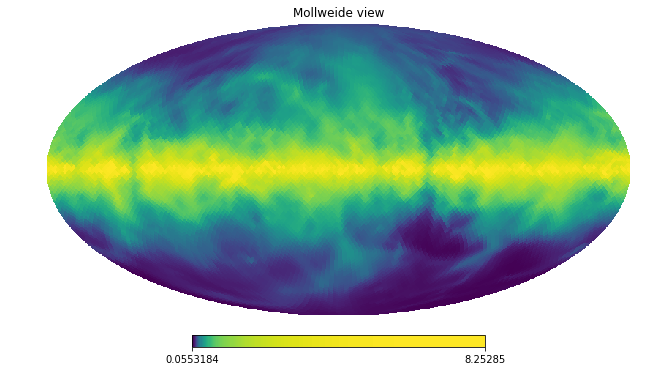

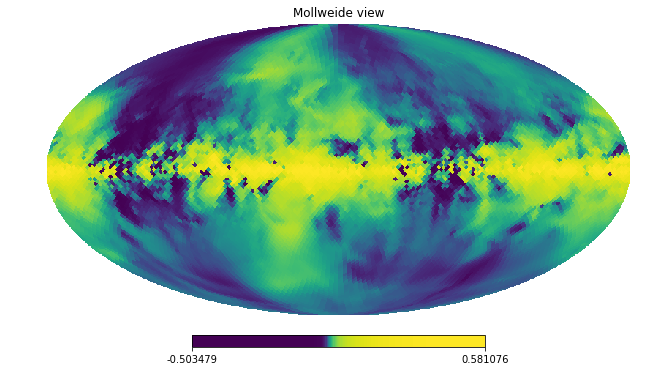

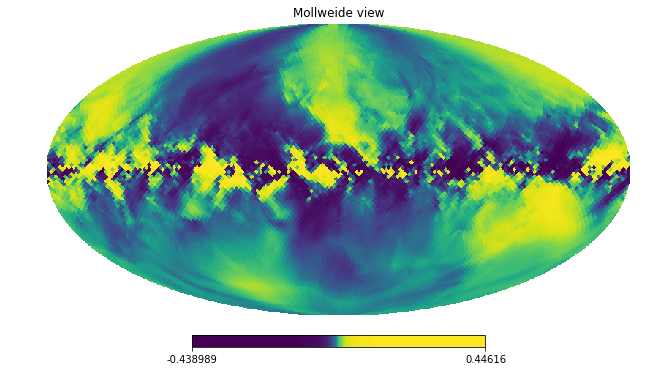

In [5]:
for i in range(3):
    hp.mollview(IQU[i].sum(axis=1),norm='hist')